In [1]:
import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipeline/'

In [2]:
#plt.style.use('dark_background') #for posters

In [421]:
#functions
def read_gap_detection_results(mhalo, rgc, mag_limit):
    f=path_pipeline+'/pipeline_rgc{}_mhalo{:.2e}_maglimit{:.2f}*.npy'.format(rgc, mhalo, mag_limit)
    print (f)
    filenames=glob.glob(f)
    #return pd.read_pickle(filenames[0])
    np.load(f, allow_pickle=True)

def show_gap_detection(res, ax, plot='None'):
    meshgrid= res['meshgrid']
    data=res['data']
    
    grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])
    #density_data= np.hstack([ xi.ravel().reshape(-1,1) for xi in res['density']])
    #min_pihpi_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in res['min_eigen']])
    #max_pihpi_data= np.hstack([ xi.ravel().reshape(-1,1) for xi in res['max_eigen']])
    
    
    gap_mask = res['max_eigen'] > np.percentile(res['max_eigen'],90. ) 
    stream_mask =res['min_eigen'] < np.percentile(res['min_eigen'],15.)
    
    stream_size= 1.5*np.nanstd(meshgrid[1][stream_mask])
    
    weights= np.ma.masked_array(res['density'].flatten(), mask= ~stream_mask.flatten(),
                                fill_value=0.).filled()
    
    #fit a polynomial that is weighted by the density
    pol=np.poly1d(np.polyfit(grid_data[:,0], grid_data[:,1], 2, w=  weights))
    
    #define stream track and gap track
    stream_track=np.logical_and(grid_data[:,1] > pol(grid_data[:,0])-stream_size/2,
                                 grid_data[:,1] < pol(grid_data[:,0])+stream_size/2)
    
    
    gap_track= np.logical_and(stream_track, gap_mask.flatten())

    gap_center=np.nanmedian(grid_data[:,0][gap_track])
    
    gap_track1= np.logical_and.reduce([stream_track, \
                                      np.abs((grid_data[:,0]-gap_center)) <0.25])
    
    #verify
    #ax.scatter(grid_data[:,0], grid_data[:,1], c=gap_track1, s=15, cmap='Greys')

                                 
    if plot=='plot1':
       
        p= ax.contour(v['meshgrid'][0], v['meshgrid'][1],  v['density'],  20, \
                          cmap='spring', alpha=.5)
        ax.contourf(v['meshgrid'][0], v['meshgrid'][1],  v['max_eigen'],  20, \
                          cmap='magma_r', alpha=1)
        #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
        #           s=1, cmap='cubehelix')
        
    if plot=='plot2':
        ax.contourf(v['meshgrid'][0], v['meshgrid'][1],  v['min_eigen'],  20, \
                          cmap='cubehelix', alpha=.1)
        p= ax.contour(v['meshgrid'][0], v['meshgrid'][1],  v['density'],  20, \
                          cmap='spring', alpha=.5)
        
    if plot=='plot3':
        #verify by plotting
        ax.scatter(v['data'][:,0], v['data'][:,1], s=.5, alpha=0.2, c='k')
        #p= ax.contour(v['meshgrid'][0], v['meshgrid'][1],  v['density'],  20, \
        #                  cmap='spring', alpha=.5)
        
        #plot stream track
        ax.plot(res['meshgrid'][0], pol(res['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
        ax.plot(res['meshgrid'][0], pol(res['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)
        
        #plot gap track
        ax.vlines(x=grid_data[:,0][gap_track1].min(), \
                   ymin=pol(grid_data[:,0][gap_track1].min())-stream_size/2,
                   ymax=pol(grid_data[:,0][gap_track1].min())+stream_size/2, color='#0074D9', linewidth=3)
        ax.vlines(x=grid_data[:,0][gap_track1].max(), \
                   ymin=pol(grid_data[:,0][gap_track1].max())-stream_size/2,
                   ymax=pol(grid_data[:,0][gap_track1].max())+stream_size/2, color='#0074D9', linewidth=3)
        #limit
        ax.set(xlim=[np.min(v['data'][:,0]), np.max(v['data'][:,0])],
               ylim=[np.min(v['data'][:,1]), np.max(v['data'][:,1])])
        
    #compute relevant statistics
    
    stats={'spread_stream_stars':x,
          'spread_gap_stars':x,
           'nstars_gap':x,
           'nstars_stream':x,
           'stream_width': stream_size,
          }
    return stats



37.453807178183204

In [278]:
50*23

1150

NameError: name 'x' is not defined

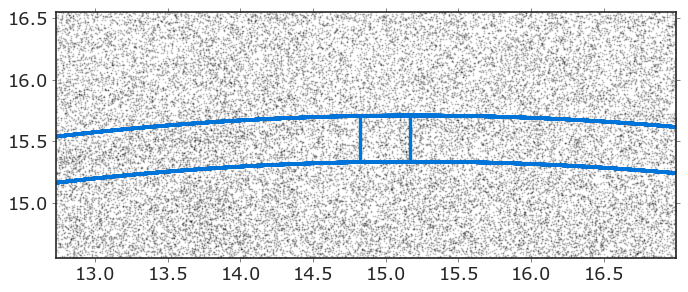

In [422]:
for f in glob.glob('../data/pipeline/*.npy'):
    vlsx=np.load(f, allow_pickle=True)
    for vls in vlsx:
        for k in vls.keys():
            v=vls[k]
            fig, ax=plt.subplots(figsize=(10, 4))
            show_gap_detection(v, ax, plot='plot3')
            
